In [1]:
import torch
import time
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, test_loop_random_start, test_loop
from double_net import datasets as ds
import double_net.plot_utils as pu
import matplotlib.pyplot as plt

In [2]:
train = True
test = True

In [3]:
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
device

'cuda'

In [6]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=0)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=10000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=100)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1.0)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
# parser.add_argument('--sinkhorn-rounds', type=int, default=20)
parser.add_argument('--sinkhorn-tol', type=float, default=0.01)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=100, num_examples=524288, random_seed=0, rgt_start=0, rho=1.0, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_tol=0.01, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=10000)

In [7]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_tol, marginal_choice='exact_one'
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [8]:
import os
dir_name = 'scaled_exact_one_1x2_experiment_data/'
os.makedirs(dir_name, exist_ok=True)

In [9]:
if train:
    start_time = time.time()
    train_loop(model, train_loader, args, device=device)
    end_time = time.time()
    with open(dir_name+'time.txt', 'w') as f:
        print(f"runtime: {end_time - start_time}", file=f)
        print(f"runtime: {end_time - start_time}")

100%|██████████| 100/100 [1:21:36<00:00, 48.96s/it]


{'regret_max': 0.5448424816131592, 'regret_mean': 0.015742210671305656, 'regret_mults': tensor([[5.6359]], device='cuda:0'), 'payment': 0.05877286195755005}
{'regret_max': 0.07196295261383057, 'regret_mean': 0.007703216280788183, 'regret_mults': tensor([[6.4146]], device='cuda:0'), 'payment': 0.07380017638206482}
{'regret_max': 0.06995272636413574, 'regret_mean': 0.005112932529300451, 'regret_mults': tensor([[7.2224]], device='cuda:0'), 'payment': 0.07083748281002045}
{'regret_max': 0.06668210029602051, 'regret_mean': 0.003815488424152136, 'regret_mults': tensor([[9.0133]], device='cuda:0'), 'payment': 0.06410682946443558}
{'regret_max': 0.059958577156066895, 'regret_mean': 0.003062198869884014, 'regret_mults': tensor([[9.9105]], device='cuda:0'), 'payment': 0.05783797428011894}
{'regret_max': 0.053939104080200195, 'regret_mean': 0.0027106483466923237, 'regret_mults': tensor([[10.7961]], device='cuda:0'), 'payment': 0.05295293405652046}
{'regret_max': 0.08750597387552261, 'regret_mean'

In [10]:
if not train:
    model = DoubleNet.load(dir_name).cuda()
else:
    model.save(dir_name)

In [11]:
%%time
# model.sinkhorn_rounds = 100
# model.sinkhorn_epsilon = 1e-2
if test:
    test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)
    # test_data = torch.load(dir_name + 'test_data').to(device=device)
    cpu_test_data = test_data.clone().to(device='cpu')

    test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

    result = test_loop(model, test_loader, args, device=device)
    result

1it [00:29, 29.14s/it]


CPU times: user 29.1 s, sys: 12 ms, total: 29.1 s
Wall time: 29.1 s


In [12]:
if test:
    args.test_num_examples = 1000
    args.test_batch_size = 1000
    args.test_misreport_iter = 1000
    args.misreport_lr = 1e-1
    test_data2 = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)
    random_starts = [test_data2]
    for i in range(10):
        random_starts.append(ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device))
    test_loader = ds.Dataloader(test_data2, batch_size=args.test_batch_size, shuffle=True)

    result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
    print(result)

1it [02:36, 156.24s/it]


{'payment_mean': 0.07880309969186783, 'regret_mean': 0.0008007679134607315, 'regret_max': 0.006203770637512207}


In [13]:
converged = model.check_convergence(torch.rand(10000,1,2).cuda())

In [14]:
converged[0].max()

tensor(1.6689e-06, device='cuda:0')

In [15]:
converged[1].max()


tensor(1.6689e-06, device='cuda:0')

In [16]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
# # model.sinkhorn_rounds = 200

/home/curry/src/MechanismDesign/double_net/plot_utils.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


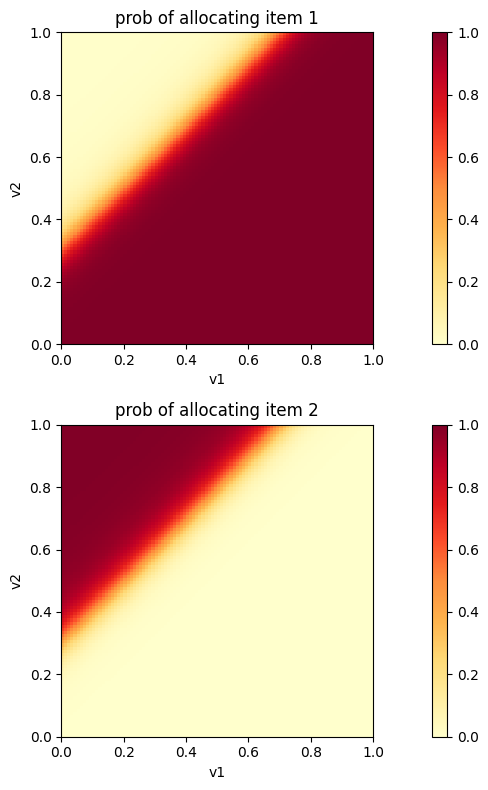

In [17]:
pu.plot_12_model(model.to(device='cpu'), 0.01, (0,1), (0,1))

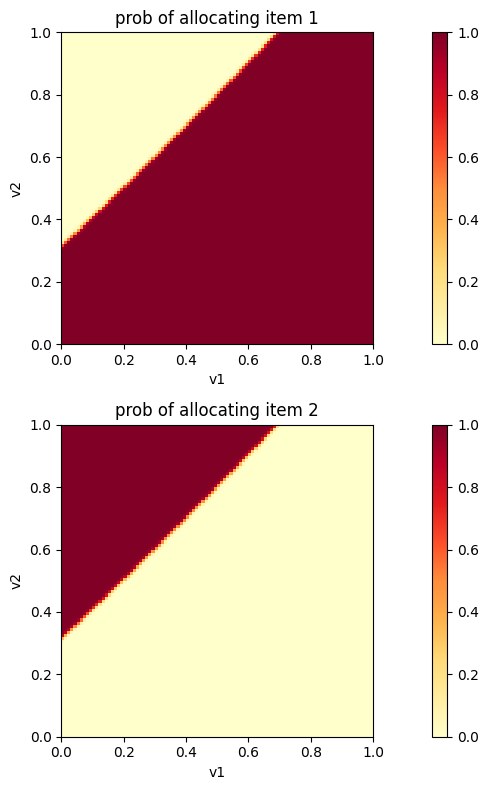

In [18]:
model.sinkhorn_epsilon = 5e-3
pu.plot_12_model(model.to(device='cpu'), 0.01, (0,1), (0,1))

In [19]:
def plot_12_model_payments(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_payments = output_payments.view(xlen, ylen)
    f, (ax1) = plt.subplots(1, 1)
    im1 = ax1.imshow(output_item1_payments.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1])
    ax1.set_title('payment')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    f.colorbar(im1)
    f.show()
    
# plot_12_model_payments(model.to(device='cpu'), 0.01, (0,1), (0,1))

In [20]:
def exact_one_1x2_0_1_optimal_mechanism(bids):
    batch_size, n_agents, n_items = bids.shape
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((batch_size, n_agents))
    
    for i in range(batch_size):
        if bids[i, 0, 1] - 1 / 3 > bids[i, 0, 0]:
            allocs[i, 0, 1] = 1.0
            allocs[i, 0, 0] = 0.0
            payments[i] = 1 / 3
        else:
            allocs[i, 0, 1] = 0.0
            allocs[i, 0, 0] = 1.0
            payments[i] = 0.0
    return allocs, payments

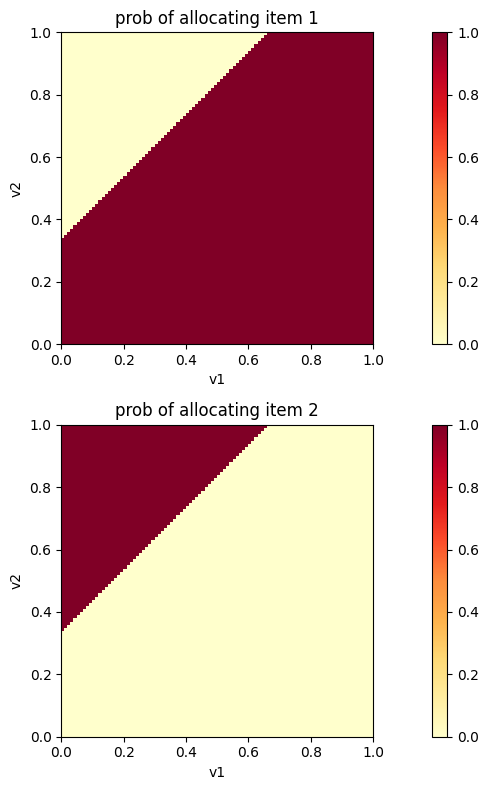

In [21]:
pu.plot_12_model(exact_one_1x2_0_1_optimal_mechanism, 0.01, (0,1), (0,1))

In [22]:
# test with higher sinkhorn
model.cuda()
model.sinkhorn_epsilon=5e-3
if test:
    args.test_num_examples = 1000
    args.test_batch_size = 1000
    args.test_misreport_iter = 1000
    args.misreport_lr = 1e-1
    test_data2 = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)
    random_starts = [test_data2]
    for i in range(10):
        random_starts.append(ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device))
    test_loader = ds.Dataloader(test_data2, batch_size=args.test_batch_size, shuffle=True)

    result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
    print(result)

1it [02:35, 155.56s/it]


{'payment_mean': 0.08184846490621567, 'regret_mean': 0.003175676567479968, 'regret_max': 0.08443701267242432}


In [27]:

def plot_12_model_opt(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    import math
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_allocs = output_allocs[:, :, 0].view(xlen, ylen)
    output_item2_allocs = output_allocs[:, :, 1].view(xlen, ylen)
    f, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(output_item1_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax1.set_title('prob of allocating item 1')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    im2 = ax2.imshow(output_item2_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax2.set_title('prob of allocating item 2')
    ax2.set_xlabel('v1')
    ax2.set_ylabel('v2')

    # Plot optimals
    ax1.plot([0, 2/3], [1/3, 1], 'k--')
    ax2.plot([0, 2/3], [1/3, 1], 'k--')

    f.colorbar(im1, ax=ax1)
    f.colorbar(im2, ax=ax2)
    f.tight_layout()
    f.show()

<ipython-input-27-17d5d61ddbd5>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


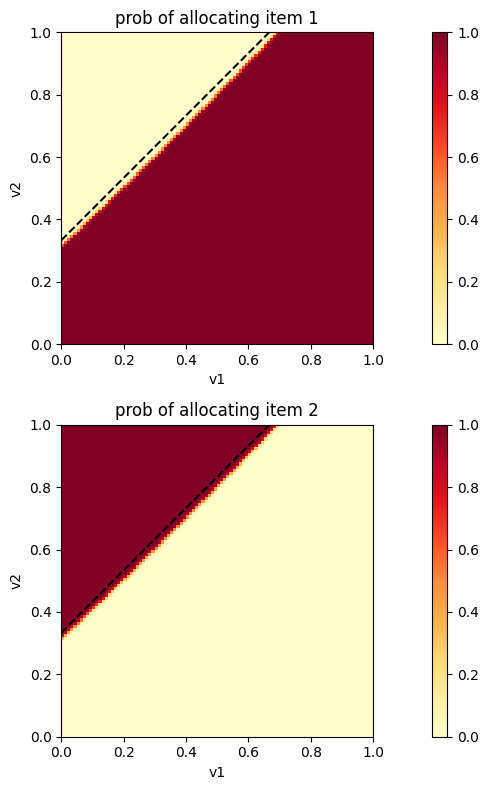

In [28]:

plot_12_model_opt(model.to('cpu'), 0.01)

<ipython-input-27-17d5d61ddbd5>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


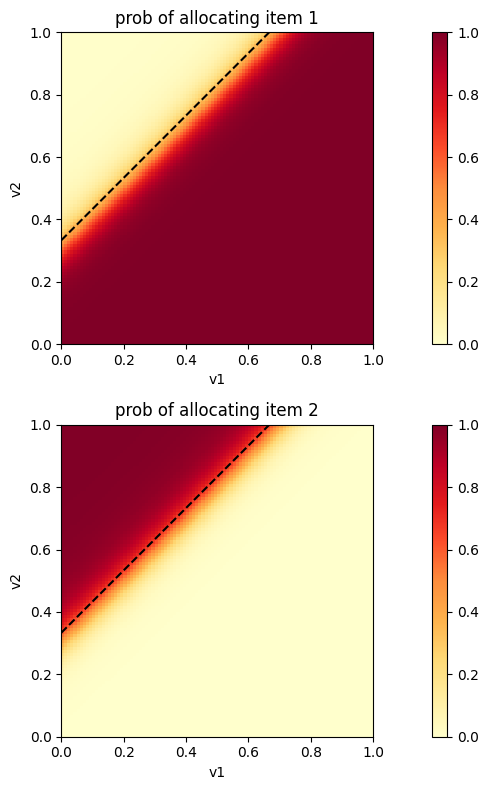

In [29]:
model.sinkhorn_epsilon = 5e-2
plot_12_model_opt(model.to('cpu'), 0.01)